# Greek Parliament Proceedings

## Dikonimaki Chrysoula

In [1]:
import math
import pandas as pd
import zipfile
import numpy as np

from plotnine import *
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats.stats as stats
import scipy.stats.stats as stats

import spacy
import el_core_news_md
from spacy.lang.el import STOP_WORDS
from spacy.tokens import Doc

import unicodedata
import re

from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import pytorch_wrapper as pw
import torch
from torch.utils.data import Dataset
import os
import uuid

from torch import nn
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from itertools import product
from transformers import AutoTokenizer, AutoModel, AdamW
from functools import partial

from conllu import parse_incr

import pytorch_wrapper.functional as pwF

from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Input
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

from collections import Counter

We will unzip and read the dataset:

In [2]:
zf = zipfile.ZipFile('Greek_Parliament_Proceedings_1989_2019.csv.zip') 
df = pd.read_csv(zf.open('Greek_Parliament_Proceedings_1989_2019.csv'))
df.head(5)

Because the dataset is extremely big and we lack of sources (gpu etc.), we are constrained to use only a small portion. 
We will use the 1.5% of it.

In [3]:
df = df.sample(frac=0.015, random_state=42) # get random entries
compression_opts = dict(method='zip',
                        archive_name='out.csv')
df.to_csv('Greek_Parliament_part1.zip',compression=compression_opts) # save new file

In [4]:
zf = zipfile.ZipFile('Greek_Parliament_part1.zip') 
df = pd.read_csv(zf.open('out.csv'))
df.head(5)

,Unnamed: 0,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,1073670,βαρεμενος βασιλειου γεωργιος,2016-09-20,period 17 presided parliamentary republic,session 1,sitting 192,συνασπισμος ριζοσπαστικης αριστερας,προεδρευων,Το σχέδιο νόμου έγινε δεκτό και στο σύνολο κα...
1,720621,γκατζης φιλιππου νικολαος,2009-07-01,period 12 presided parliamentary republic,'09 summer recess section 1,sitting 11,κομμουνιστικο κομμα ελλαδας,NaN,Κατά πλειοψηφία.
2,538543,καλος βασιλειου γεωργιος,2005-05-30,period 11 presided parliamentary republic,session 1 continuation of plenary session,sitting 172,νεα δημοκρατια,υφυπουργος εθνικης παιδειας και θρησκευματων,"Κύριε Πρόεδρε, θα ήθελα να δηλώσω ότι θα απαν..."
3,464616,κακλαμανης χρηστου αποστολος,2003-02-05,period 10 presided parliamentary republic,session 3,sitting 66,πανελληνιο σοσιαλιστικο κινημα,προεδρος,"Ναι, μάλλον την Τρίτη. Επομένως για την αυρια..."
4,389054,γειτονας ιωαννη κωνσταντινος,2001-02-12,period 10 presided parliamentary republic,session 1 continuation of plenary session,sitting 111,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κυρίες και κύριοι συνάδελφοι, έχω την τιμή να..."


In [5]:
df.sitting_date = pd.to_datetime(df.sitting_date)

We will drop nan records:

In [6]:
df.dropna(subset=['political_party', 'speech'], inplace=True)

## Data Exploration

The 8 columns of the dataset are shown below:

In [7]:
df.columns.tolist()

['Unnamed: 0',
 'member_name',
 'sitting_date',
 'parliamentary_period',
 'parliamentary_session',
 'parliamentary_sitting',
 'political_party',
 'speaker_info',
 'speech']

We will give a briefly description:

| member_name |sitting_date|parliamentary_period|parliamentary_session|parliamentary_sitting|political_party|speaker_info|speech
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|speaker's name| date of the speech|parliament period|parliamentary session|parliamentary sitting|political party|speaker info|the actual speech

There are 23 political parties (and some nan values) and 1300 members:

In [8]:
len(df.political_party.unique())

21

In [9]:
len(df.member_name.unique())

972

In [10]:
df.political_party.unique().tolist()

['συνασπισμος ριζοσπαστικης αριστερας',
 'κομμουνιστικο κομμα ελλαδας',
 'νεα δημοκρατια',
 'πανελληνιο σοσιαλιστικο κινημα',
 'το ποταμι',
 'βουλη',
 'συνασπισμος της αριστερας των κινηματων και της οικολογιας',
 'λαικος ορθοδοξος συναγερμος',
 'λαικος συνδεσος - χρυση αυγη',
 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
 'ανεξαρτητοι ελληνες - πανος καμμενος',
 'ανεξαρτητοι (εκτος κομματος)',
 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
 'ενωση κεντρωων',
 'δημοκρατικη αριστερα',
 'δημοκρατικο κοινωνικο κινημα',
 'πολιτικη ανοιξη',
 'ανεξαρτητοι δημοκρατικοι βουλευτες',
 'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)',
 'λαικη ενοτητα',
 'κομμουνιστικο κομμα ελλαδας εσωτερικου']

Speeches per party:

Some parties have few speeches so we will exclude them. \
We are going to exclude parties with lower than 300 speeches.

In [11]:
sorted_parties = df.groupby('political_party').count()['speech'].reset_index().sort_values(by=['speech'], ascending=False)
sorted_parties

,political_party,speech
14,νεα δημοκρατια,5865
16,πανελληνιο σοσιαλιστικο κινημα,5641
18,συνασπισμος ριζοσπαστικης αριστερας,1847
9,κομμουνιστικο κομμα ελλαδας,1138
4,βουλη,675
19,συνασπισμος της αριστερας των κινηματων και τη...,550
0,ανεξαρτητοι (εκτος κομματος),467
12,λαικος ορθοδοξος συναγερμος,374
6,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,338
13,λαικος συνδεσος - χρυση αυγη,210


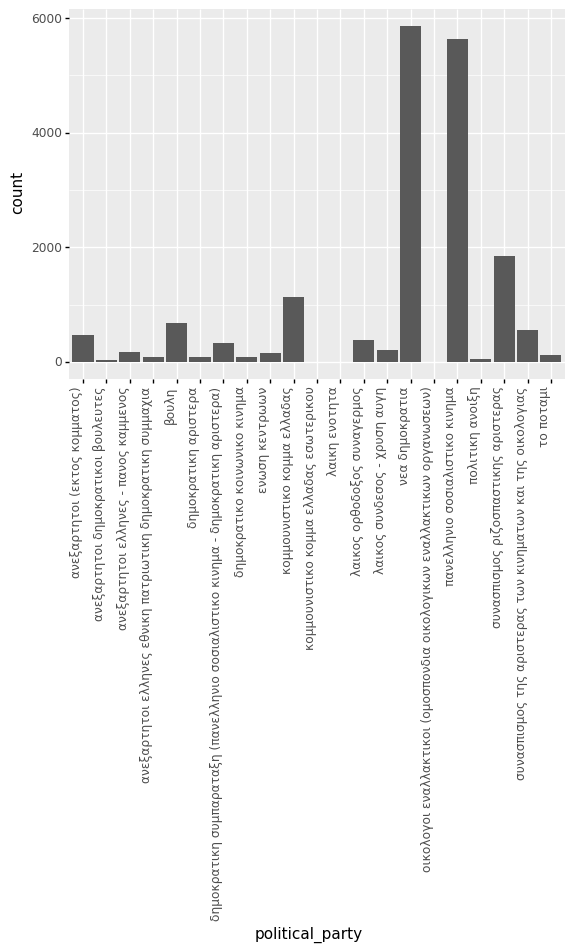

<ggplot: (8789294199830)>

In [12]:
ggplot(aes(x="political_party", weight="speech"), sorted_parties) + geom_bar() +\
    theme(axis_text_x  = element_text(angle = 90, hjust = 1))

We will focus on all political parties except the first 15 ones:

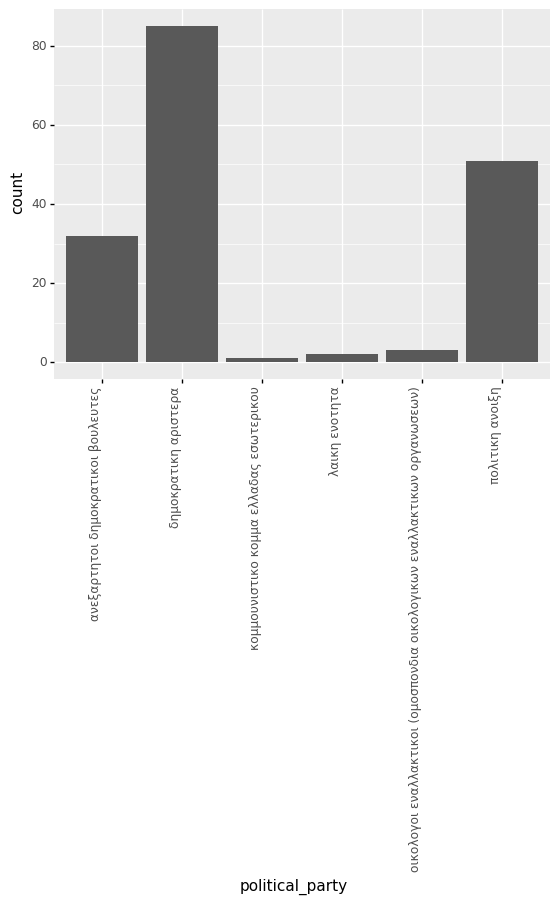

<ggplot: (-9223363247560719300)>

In [13]:
ggplot(aes(x="political_party", weight="speech"), sorted_parties.iloc[15:len(sorted_parties),:]) + geom_bar() +\
    theme(axis_text_x  = element_text(angle = 90, hjust = 1))

We will exclude parties with lower than 500 speeches

In [14]:
thres = 100
excluded_names = sorted_parties[sorted_parties.speech<thres].political_party.tolist()
excluded_names

['δημοκρατικο κοινωνικο κινημα',
 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
 'δημοκρατικη αριστερα',
 'πολιτικη ανοιξη',
 'ανεξαρτητοι δημοκρατικοι βουλευτες',
 'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)',
 'λαικη ενοτητα',
 'κομμουνιστικο κομμα ελλαδας εσωτερικου']

In [15]:
df = df[~df.political_party.isin(excluded_names)]

Speeches over time:

In [16]:
df.groupby('sitting_date').count()['speech'].reset_index()

,sitting_date,speech
0,1989-07-05,1
1,1989-07-07,4
2,1989-07-08,1
3,1989-07-12,1
4,1989-07-14,3
...,...,...
4146,2019-02-15,2
4147,2019-02-19,3
4148,2019-02-20,5
4149,2019-02-21,5


Grouped per year is probably more interesting

In [17]:
df.loc[:,'year'] = pd.DatetimeIndex(df['sitting_date']).year

In [18]:
year = df.groupby('year').count()['speech'].reset_index()

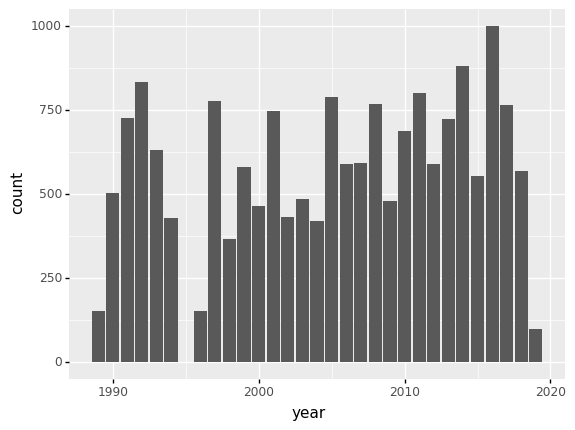

<ggplot: (8789294062326)>

In [19]:
ggplot(aes(x="year", weight="speech"), year) + geom_bar() 

Speeches per party and time:

In [20]:
political_party_year = df.groupby(['political_party','year']).count()['speech'].reset_index().sort_values(by=['speech'], ascending=False)
political_party_year

,political_party,year,speech
146,πανελληνιο σοσιαλιστικο κινημα,1997,489
124,νεα δημοκρατια,2005,461
150,πανελληνιο σοσιαλιστικο κινημα,2001,413
148,πανελληνιο σοσιαλιστικο κινημα,1999,379
127,νεα δημοκρατια,2008,360
...,...,...,...
165,πανελληνιο σοσιαλιστικο κινημα,2016,1
65,κομμουνιστικο κομμα ελλαδας,1989,1
20,ανεξαρτητοι ελληνες - πανος καμμενος,2009,1
6,ανεξαρτητοι (εκτος κομματος),2004,1


In [21]:
political_party_year[political_party_year.speech<100].groupby('political_party').sum()['speech'].reset_index()

,political_party,speech
0,ανεξαρτητοι (εκτος κομματος),467
1,ανεξαρτητοι ελληνες - πανος καμμενος,181
2,βουλη,675
3,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,108
4,ενωση κεντρωων,149
5,κομμουνιστικο κομμα ελλαδας,1138
6,λαικος ορθοδοξος συναγερμος,259
7,λαικος συνδεσος - χρυση αυγη,210
8,νεα δημοκρατια,116
9,πανελληνιο σοσιαλιστικο κινημα,188


Speakers per party:

In [22]:
df.groupby(['member_name']).count()['speech'].reset_index().sort_values(by=['speech'], ascending=False)

,member_name,speech
264,κακλαμανης χρηστου αποστολος,518
738,σγουριδης σγουρη παναγιωτης,486
766,σουρλας ιωαννη γεωργιος,445
420,κρητικος νικολαου παναγιωτης,362
839,τραγακης παναγιωτη ιωαννης,296
...,...,...
791,σταυρογιαννης δημητριου νικολαος,1
793,στεργιου ελευθεριου κωνσταντινος,1
287,κανελλοπουλου αθανασιου κρινιω,1
636,παπαδοπουλος κωνσταντινου χριστοφορος,1


Speakers per party and date:

In [23]:
df.groupby(['member_name','year']).count()['speech'].reset_index()

,member_name,year,speech
0,αβραμιδης νικολαου γαβριηλ,2013,2
1,αβραμιδης νικολαου γαβριηλ,2014,1
2,αβραμοπουλος λαμπρου δημητριος,1994,1
3,αβραμοπουλος λαμπρου δημητριος,2005,3
4,αβραμοπουλος λαμπρου δημητριος,2007,2
...,...,...,...
4005,ψαριανος νικολαου γρηγοριος,2018,1
4006,ψυχαρης σταυρου ανδρεας,2014,1
4007,ψωμιαδης χαραλαμπους παναγιωτης,1996,1
4008,ψωμιαδης χαραλαμπους παναγιωτης,1997,1


# Classification without Neural Networks

## Preprocessing

We will use spacy in order to remove stop words and punctuation. Also, we will save the words' lemma.

In [24]:
nlp = el_core_news_md.load()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

new_speech = []
for doc in tokenizer.pipe(df['speech'].tolist(), batch_size=100):
    new_speech.append(' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_stop]))

In [25]:
df['new_speech'] = new_speech

## Splitting the dataset

Now, we will split the data into 2 sets: train, test

In [26]:
X = df.new_speech.tolist() # get speeches
y = df.political_party.tolist() # get targets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We will get the classes we want to predict:

In [28]:
classes = df.political_party.unique().tolist()
classes

['συνασπισμος ριζοσπαστικης αριστερας',
 'κομμουνιστικο κομμα ελλαδας',
 'νεα δημοκρατια',
 'πανελληνιο σοσιαλιστικο κινημα',
 'το ποταμι',
 'βουλη',
 'συνασπισμος της αριστερας των κινηματων και της οικολογιας',
 'λαικος ορθοδοξος συναγερμος',
 'λαικος συνδεσος - χρυση αυγη',
 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
 'ανεξαρτητοι ελληνες - πανος καμμενος',
 'ανεξαρτητοι (εκτος κομματος)',
 'ενωση κεντρωων']

In [29]:
len(classes)

13

We are going to represent the data using the follow techniques: 
<ul>
    <li>Bag of words</li>
    <li>Tf-idf</li>
</ul>

Moreover, we are going to use the following machine learning algorithms and techniques: 
<ul>
    <li>Logistic Regression</li>
    <li>Random Forest</li>
</ul>
But, first of all, we will check the DummyClassifier results.

First of all, we will initialiaze some useful functions:

#### Bag of words / TF-IDF:

Creating bag of words and tf-idf representations:

In [30]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train) #fit and tranform

In [31]:
X_test_bow = vectorizer.transform(X_test) # transorm set

In [32]:
tfidf_vectorizer = TfidfVectorizer() 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Dummy Classifier results:

In [33]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
predicted = dummy_clf.predict(X_test)
print(metrics.classification_report(y_test , predicted, zero_division=0))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.07      0.06      0.06        84
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.00      0.00      0.00        27
                                                                          βουλη       0.03      0.04      0.04       136
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.00      0.00      0.00        62
                                                                 ενωση κεντρωων       0.00      0.00      0.00        26
                                                    κομμουνιστικο κομμα ελλαδας       0.06      0.05      0.05       247
                                                    λαικος ορθοδοξος συναγερμος       0.03      0.03      0.03        69
                               

### Logistic Regression

We will use cross validation on the training set in order to find the best hyperparameters:

We will define some possible hyperparameters:

In [34]:
C = [100, 10, 1.0, 0.1, 0.01]

# according to the documentation l2 penalty can support only those 3 solvers
solver  = ['newton-cg', 'lbfgs', 'sag'] 

hyperparameters = dict(C=C, solver=solver)

In [35]:
l_clf = LogisticRegression()

cv = RandomizedSearchCV(l_clf, hyperparameters, n_iter=5, scoring='f1_macro', n_jobs=-1)
best_model = cv.fit(X_train_bow, y_train)

/home/cdikonimaki/GreekBERT/env/local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [36]:
best_params = best_model.best_estimator_.get_params()
best_params

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [37]:
predicted = best_model.best_estimator_.predict(X_test_bow)
print(metrics.classification_report(y_test , predicted, zero_division=0))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.13      0.04      0.06        84
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.00      0.00      0.00        27
                                                                          βουλη       0.72      0.64      0.68       136
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.03      0.02      0.02        62
                                                                 ενωση κεντρωων       0.00      0.00      0.00        26
                                                    κομμουνιστικο κομμα ελλαδας       0.36      0.36      0.36       247
                                                    λαικος ορθοδοξος συναγερμος       0.14      0.04      0.07        69
                               

In [38]:
l_clf = LogisticRegression()

cv = RandomizedSearchCV(l_clf, hyperparameters, n_iter=5, scoring='f1_macro', n_jobs=-1)
best_model = cv.fit(X_train_tfidf, y_train)

In [39]:
best_params = best_model.best_estimator_.get_params()
best_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [40]:
predicted = best_model.best_estimator_.predict(X_test_tfidf)
print(metrics.classification_report(y_test , predicted, zero_division=0))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.00      0.00      0.00        84
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.00      0.00      0.00        27
                                                                          βουλη       0.78      0.64      0.70       136
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.00      0.00      0.00        62
                                                                 ενωση κεντρωων       0.00      0.00      0.00        26
                                                    κομμουνιστικο κομμα ελλαδας       0.40      0.26      0.32       247
                                                    λαικος ορθοδοξος συναγερμος       0.00      0.00      0.00        69
                               

### RandomForestClassifier

We will use cross validation on the training set in order to find the best hyperparameters:

We will define some possible hyperparameters:

In [41]:
max_depth = list(range(10, 200, 10))
max_depth.append(None)

max_features = ['auto', 'sqrt']
n_estimators = list(range(200, 2000,200))

hyperparameters = dict(max_depth=max_depth, max_features=max_features, n_estimators=n_estimators)

We will use randomized search cross-validation in order to find the best hyperparameters:

In [42]:
rf_clf = RandomForestClassifier()

cv = RandomizedSearchCV(rf_clf, hyperparameters, n_iter=5, scoring='f1_macro', n_jobs=-1)
best_model = cv.fit(X_train_bow, y_train)

In [43]:
best_params = best_model.best_estimator_.get_params()
best_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 180,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [44]:
predicted = best_model.best_estimator_.predict(X_test_bow)
print(metrics.classification_report(y_test , predicted, zero_division=0))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.50      0.01      0.02        84
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.00      0.00      0.00        27
                                                                          βουλη       0.79      0.64      0.71       136
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.00      0.00      0.00        62
                                                                 ενωση κεντρωων       0.00      0.00      0.00        26
                                                    κομμουνιστικο κομμα ελλαδας       0.41      0.20      0.27       247
                                                    λαικος ορθοδοξος συναγερμος       0.00      0.00      0.00        69
                               

In [45]:
rf_clf = RandomForestClassifier()

cv = RandomizedSearchCV(rf_clf, hyperparameters, scoring='f1_macro', n_jobs=-1)
best_model = cv.fit(X_train_tfidf, y_train)

In [46]:
best_params = best_model.best_estimator_.get_params()
best_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 190,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [47]:
predicted = best_model.best_estimator_.predict(X_test_tfidf)
print(metrics.classification_report(y_test , predicted, zero_division=0))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.00      0.00      0.00        84
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.00      0.00      0.00        27
                                                                          βουλη       0.78      0.63      0.70       136
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.33      0.02      0.03        62
                                                                 ενωση κεντρωων       0.00      0.00      0.00        26
                                                    κομμουνιστικο κομμα ελλαδας       0.44      0.23      0.30       247
                                                    λαικος ορθοδοξος συναγερμος       0.00      0.00      0.00        69
                               

In [71]:
target_names = best_model.classes_

In [72]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

c:\users\xrisa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


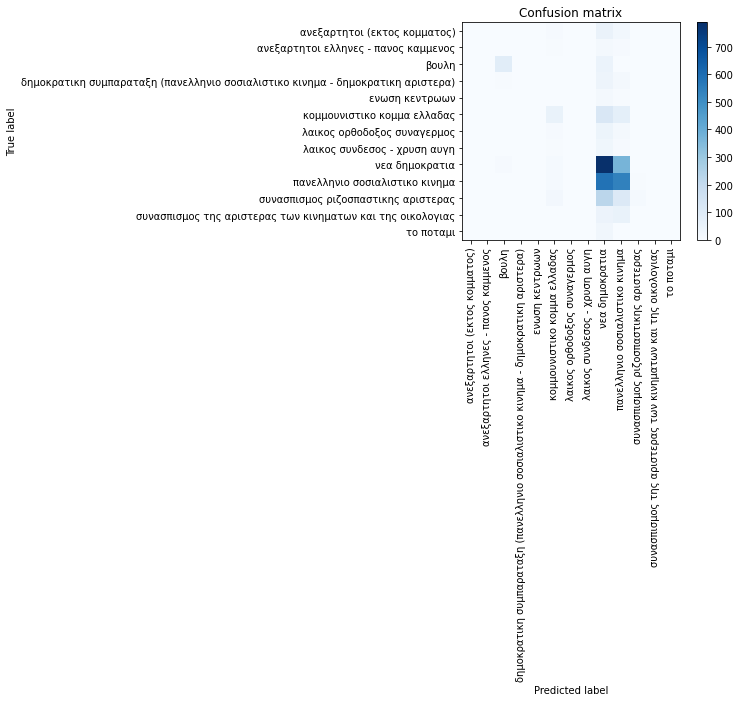

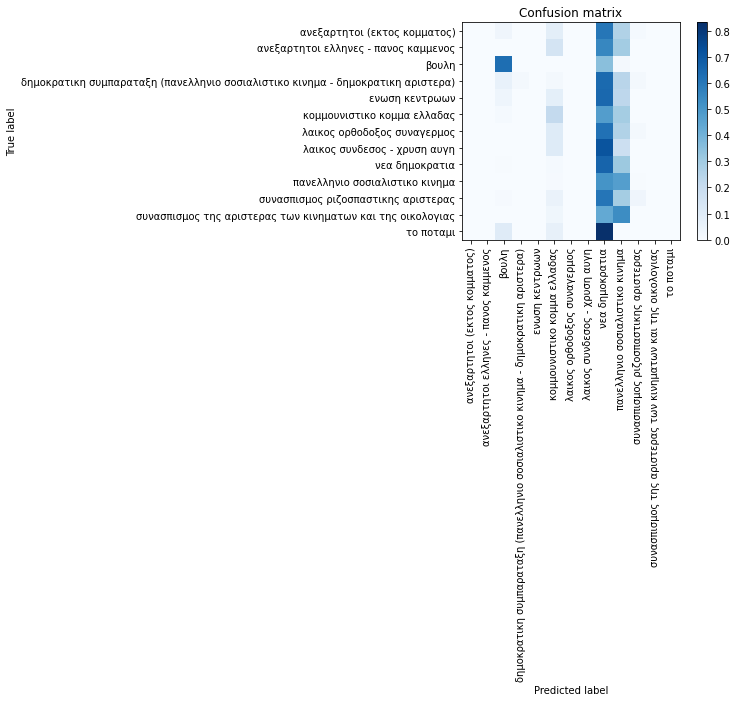

In [73]:
cm = confusion_matrix(y_test, predicted)
plot_confusion_matrix(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized)

It is clear that most of the classes was wrongly predicted as the two most popular parties. It may happen because those parties have the most examples in the dataset (actually, 1.5% of it) and our model is not able to learn to predict those classes. <b >
So, we will check if the most wrongly predicted classes are from the same political position with those two parties because sometimes they may use the same worlds and may express similar ideas.

In [76]:
target_names

array(['ανεξαρτητοι (εκτος κομματος)',
       'ανεξαρτητοι ελληνες - πανος καμμενος', 'βουλη',
       'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
       'ενωση κεντρωων', 'κομμουνιστικο κομμα ελλαδας',
       'λαικος ορθοδοξος συναγερμος', 'λαικος συνδεσος - χρυση αυγη',
       'νεα δημοκρατια', 'πανελληνιο σοσιαλιστικο κινημα',
       'συνασπισμος ριζοσπαστικης αριστερας',
       'συνασπισμος της αριστερας των κινηματων και της οικολογιας',
       'το ποταμι'], dtype='<U79')

In [77]:
r = ['ανεξαρτητοι ελληνες - πανος καμμενος','λαικος ορθοδοξος συναγερμος','λαικος συνδεσος - χρυση αυγη','νεα δημοκρατια']
l= ['δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
    'κομμουνιστικο κομμα ελλαδας','πανελληνιο σοσιαλιστικο κινημα',
    'συνασπισμος ριζοσπαστικης αριστερας','συνασπισμος της αριστερας των κινηματων και της οικολογιας']
c=['ενωση κεντρωων','το ποταμι']

In [93]:
def check_political_position(position, spec_p):
    c=0
    for y,p in zip(y_test,predicted):
        if(y!=p and y in position and p==spec_p):
            c=c+1
    print(c)

In [96]:
check_political_position(r,'νεα δημοκρατια')
check_political_position(l,'νεα δημοκρατια')

86
1011


In [97]:
check_political_position(r,'πανελληνιο σοσιαλιστικο κινημα')
check_political_position(l,'πανελληνιο σοσιαλιστικο κινημα')

405
249


However, it's clear that it doesn't happen and political position doesn't affect the way our model predict.

## Classification with a Neural Network

We are going to use GreekBert pre-trained language model (https://github.com/nlpaueb/greek-bert). <br>
We will read the dataset again because the preprocessing will be different. Also, we will exclude the same parties again.

In [3]:
zf = zipfile.ZipFile('Greek_Parliament_part1.zip') 
df = pd.read_csv(zf.open('out.csv'))
df.head(5)

,Unnamed: 0,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,1073670,βαρεμενος βασιλειου γεωργιος,2016-09-20,period 17 presided parliamentary republic,session 1,sitting 192,συνασπισμος ριζοσπαστικης αριστερας,προεδρευων,Το σχέδιο νόμου έγινε δεκτό και στο σύνολο κα...
1,720621,γκατζης φιλιππου νικολαος,2009-07-01,period 12 presided parliamentary republic,'09 summer recess section 1,sitting 11,κομμουνιστικο κομμα ελλαδας,NaN,Κατά πλειοψηφία.
2,538543,καλος βασιλειου γεωργιος,2005-05-30,period 11 presided parliamentary republic,session 1 continuation of plenary session,sitting 172,νεα δημοκρατια,υφυπουργος εθνικης παιδειας και θρησκευματων,"Κύριε Πρόεδρε, θα ήθελα να δηλώσω ότι θα απαν..."
3,464616,κακλαμανης χρηστου αποστολος,2003-02-05,period 10 presided parliamentary republic,session 3,sitting 66,πανελληνιο σοσιαλιστικο κινημα,προεδρος,"Ναι, μάλλον την Τρίτη. Επομένως για την αυρια..."
4,389054,γειτονας ιωαννη κωνσταντινος,2001-02-12,period 10 presided parliamentary republic,session 1 continuation of plenary session,sitting 111,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κυρίες και κύριοι συνάδελφοι, έχω την τιμή να..."


In [4]:
df.sitting_date = pd.to_datetime(df.sitting_date)

In [5]:
df.dropna(subset=['political_party', 'speech'], inplace=True)

In [6]:
sorted_parties = df.groupby('political_party').count()['speech'].reset_index().sort_values(by=['speech'], ascending=False)
sorted_parties

,political_party,speech
14,νεα δημοκρατια,5865
16,πανελληνιο σοσιαλιστικο κινημα,5641
18,συνασπισμος ριζοσπαστικης αριστερας,1847
9,κομμουνιστικο κομμα ελλαδας,1138
4,βουλη,675
19,συνασπισμος της αριστερας των κινηματων και τη...,550
0,ανεξαρτητοι (εκτος κομματος),467
12,λαικος ορθοδοξος συναγερμος,374
6,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,338
13,λαικος συνδεσος - χρυση αυγη,210


In [7]:
thres = 100
excluded_names = sorted_parties[sorted_parties.speech<thres].political_party.tolist()
excluded_names

['δημοκρατικο κοινωνικο κινημα',
 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
 'δημοκρατικη αριστερα',
 'πολιτικη ανοιξη',
 'ανεξαρτητοι δημοκρατικοι βουλευτες',
 'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)',
 'λαικη ενοτητα',
 'κομμουνιστικο κομμα ελλαδας εσωτερικου']

In [8]:
df = df[~df.political_party.isin(excluded_names)]

We will split the dataset into three subsets (train, dev, test)

In [9]:
X = df.speech.tolist() # get speeches
y = df.political_party.tolist() # get targets

# train, test = np.split(df.sample(frac=1, random_state=42)[['speech','political_party']], 
#                        [int(.9*len(df))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0)

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.01, random_state=0)

In [10]:
train_data = zip(X_train, y_train)
test_data = zip(X_test, y_test)
dev_data = zip(X_dev, y_dev)

We will preprocess texts to lowercase letters and remove all Greek diacritics using the following function:

In [12]:
def strip_accents_and_lowercase(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

We will use the same 13 parties as we did before and will map each party to a specific number. 

In [13]:
I2L = df.political_party.unique().tolist()
L2I = {k: i for i, k in enumerate(I2L)}

Our model will have the same number of outputs as the number of parties.

In [14]:
out_len = len(df.political_party.unique())

We will create the model class with the layers shown above. <br />
We will use dropout layer which randomly sets some units to 0 to precent model from overfitting.

In [15]:
class customModel(nn.Module):
    def __init__(self, bert_model, dp):
        """
        :param dp: the drop out probability
        """
        super(customModel, self).__init__()
        self._bert_model = bert_model
        self._dp = nn.Dropout(dp)
        self.linear = nn.Linear(768, out_len)

    def forward(self, text, text_len):
        attention_mask = pwF.create_mask_from_length(text_len, text.shape[1])
        bert = self._bert_model(text, attention_mask=attention_mask)
        cls_token = bert[1]
        output_linear = self.linear(self._dp(cls_token))
        return output_linear

Padding function: <br >
We need this in order to have inputs with the same size (the same number of words).

In [16]:
def pad_to_max(lst, max_len=None, pad_value=0):
    pad = len(max(lst, key=len))
    if max_len is not None:
        pad = min(max_len, pad)

    return [i + [pad_value for _ in range(pad - len(i))] if len(i) <= pad else i[:pad] for i in lst]

Function which returns the evaluators for the model:

In [17]:
def get_evaluators():
        evals = {}
        evals['f1-macro'] = pw.evaluators.MultiClassF1Evaluator(average='macro')
        evals['f1-micro'] = pw.evaluators.MultiClassF1Evaluator(average='micro')
        return evals

Function which process an example:
Because the Bert lack of ability to handle long text sequence and some of our examples are longer than 512 (which is the limit) we have to choose how to exclude some words. According to this paper (https://arxiv.org/abs/1905.05583),the best option is to cut out the middle of the text (rather than truncate the beginning or the end), so we will follow this approach.

In [18]:
def process_example(tokens, tokenizer, bert_like_special_tokens):
    transformer_tokens = [tokenizer.cls_token_id] if bert_like_special_tokens else [tokenizer.bos_token_id]
    is_subtoken = [0]
    for token in tokens: 
        processed_token = strip_accents_and_lowercase(token)
        current_tokens = tokenizer.encode(processed_token, add_special_tokens=False)
        if len(current_tokens) == 0:
            current_tokens = [tokenizer.unk_token_id]
        transformer_tokens.extend(current_tokens)
        
        is_subtoken.extend([1] + [0] * (len(current_tokens) - 1))
    transformer_tokens.append(tokenizer.sep_token_id if bert_like_special_tokens else tokenizer.eos_token_id)
    l = len(transformer_tokens)
    if(l>512):
        new_tokens = []
        middle = 256 # 512/2
        if(is_subtoken[middle]==0): #is subtoken
            middle = is_subtoken.index(1, middle) -1 #find next token
        new_tokens = transformer_tokens[:middle] + transformer_tokens[l-(512-middle):]
        transformer_tokens = new_tokens
        
    return transformer_tokens, len(transformer_tokens)

Function which creates batches:

In [19]:
def collate_fn(batch, pad_value):
    batch_zipped = list(zip(*batch))
    input_zipped = list(zip(*batch_zipped[1]))
        
    ids = batch_zipped[0]
    texts = torch.tensor(pad_to_max(input_zipped[0], pad_value=pad_value), dtype=torch.long)
    text_lens = torch.tensor(input_zipped[1], dtype=torch.int)
    
    target = torch.tensor(batch_zipped[2], dtype=torch.long)

    batch = {
        'id': ids,
        'input': [texts, text_lens],
        'target': target
    }
    return batch

Dataset class:

In [20]:
class customDataset(Dataset):
    def __init__(self, data, tokenizer, bert_like_special_tokens=True):
        self.ids = []
        self.texts = []
        self.text_lens = []
        self.target = []
        for i, row in enumerate(data):
            cur_texts, cur_text_lens = process_example(
                row[0].split(),
                tokenizer,
                bert_like_special_tokens
            )
            self.ids.append(i)
            self.texts.append(cur_texts)
            self.text_lens.append(cur_text_lens)
            self.target.append(L2I.get(row[1],-1))

    def __getitem__(self, index):
        return (
            self.ids[index],
            (self.texts[index], self.text_lens[index]),
            self.target[index]
        )

    def __len__(self):
        return len(self.ids)

Some useful parameters:

In [21]:
dp = 0.2
lr = 2e-05
batch_size = 4
grad_accumulation_steps = 2
pretrained_bert_name = 'nlpaueb/bert-base-greek-uncased-v1'
model_params = {'dp': dp}

Bert model definition:

In [22]:
bert_model = AutoModel.from_pretrained(pretrained_bert_name)
tokenizer = AutoTokenizer.from_pretrained(pretrained_bert_name)
pad_value = tokenizer.pad_token_id

model = customModel(bert_model ,**model_params)

if torch.cuda.is_available():
    system = pw.System(model, last_activation=nn.Softmax(dim=-1), device=torch.device('cuda'))
else:
    system = pw.System(model, last_activation=nn.Softmax(dim=-1), device=torch.device('cpu'))

We will load the data:

In [23]:
torch.manual_seed(0)
      
train_dataset = customDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size, collate_fn=partial(collate_fn, pad_value=pad_value))

test_dataset = customDataset(test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size, collate_fn=partial(collate_fn, pad_value=pad_value))

dev_dataset = customDataset(dev_data, tokenizer)
dev_dataloader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=batch_size, collate_fn=partial(collate_fn, pad_value=pad_value))

We will use cross entropy loss and adamw optimizer:

In [24]:
loss_wrapper = pw.loss_wrappers.GenericPointWiseLossWrapper(nn.CrossEntropyLoss())
optimizer = AdamW(system.model.parameters(), lr=lr)

In [25]:
base_es_path = f'/tmp/{uuid.uuid4().hex[:30]}/'
os.makedirs(base_es_path, exist_ok=True)

Now, it's time to train the model:

In [26]:
_ = system.train(loss_wrapper, optimizer, train_data_loader=train_dataloader, evaluation_data_loaders={'val': dev_dataloader},
            evaluators= get_evaluators(),
            gradient_accumulation_steps=grad_accumulation_steps,
            callbacks=[
                pw.training_callbacks.EarlyStoppingCriterionCallback(
                    patience=3,
                    evaluation_data_loader_key='val',
                    evaluator_key='f1-macro',
                    tmp_best_state_filepath=f'{base_es_path}/temp.es.weights'
                )
            ],
            verbose=False
        )

val
macro-f1: 0.1505
micro-f1: 0.3793
val
macro-f1: 0.2171
micro-f1: 0.5000
val
macro-f1: 0.2195
micro-f1: 0.4770
val
macro-f1: 0.2777
micro-f1: 0.4713
val
macro-f1: 0.2224
micro-f1: 0.4885
val
macro-f1: 0.2500
micro-f1: 0.4425
val
macro-f1: 0.3185
micro-f1: 0.4770
val
macro-f1: 0.3201
micro-f1: 0.5172
val
macro-f1: 0.3055
micro-f1: 0.5057
val
macro-f1: 0.2549
micro-f1: 0.4885
val
macro-f1: 0.2470
micro-f1: 0.5115
val
macro-f1: 0.2637
micro-f1: 0.5057


Finally, we have the following results:

In [27]:
results = system.evaluate(test_dataloader, get_evaluators(), verbose=False)
print(results)

{'f1-macro': macro-f1: 0.2593, 'f1-micro': micro-f1: 0.3750}


Because the results  wasn't good enough, we will get 5% of the dataset.

In [2]:
zf = zipfile.ZipFile('Greek_Parliament_Proceedings_1989_2019.csv.zip') 
df = pd.read_csv(zf.open('Greek_Parliament_Proceedings_1989_2019.csv'))
df.head(5)

df = df.sample(frac=0.05, random_state=42) 
compression_opts = dict(method='zip',
                        archive_name='out.csv')
df.to_csv('Greek_Parliament_part1.zip',compression=compression_opts)

In [3]:
zf = zipfile.ZipFile('Greek_Parliament_part2.zip') 
df = pd.read_csv(zf.open('out.csv'))
df.head(5)

,Unnamed: 0,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,1073670,βαρεμενος βασιλειου γεωργιος,2016-09-20,period 17 presided parliamentary republic,session 1,sitting 192,συνασπισμος ριζοσπαστικης αριστερας,προεδρευων,Το σχέδιο νόμου έγινε δεκτό και στο σύνολο κα...
1,720621,γκατζης φιλιππου νικολαος,2009-07-01,period 12 presided parliamentary republic,'09 summer recess section 1,sitting 11,κομμουνιστικο κομμα ελλαδας,NaN,Κατά πλειοψηφία.
2,538543,καλος βασιλειου γεωργιος,2005-05-30,period 11 presided parliamentary republic,session 1 continuation of plenary session,sitting 172,νεα δημοκρατια,υφυπουργος εθνικης παιδειας και θρησκευματων,"Κύριε Πρόεδρε, θα ήθελα να δηλώσω ότι θα απαν..."
3,464616,κακλαμανης χρηστου αποστολος,2003-02-05,period 10 presided parliamentary republic,session 3,sitting 66,πανελληνιο σοσιαλιστικο κινημα,προεδρος,"Ναι, μάλλον την Τρίτη. Επομένως για την αυρια..."
4,389054,γειτονας ιωαννη κωνσταντινος,2001-02-12,period 10 presided parliamentary republic,session 1 continuation of plenary session,sitting 111,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κυρίες και κύριοι συνάδελφοι, έχω την τιμή να..."


In [4]:
df.sitting_date = pd.to_datetime(df.sitting_date)

In [5]:
df.dropna(subset=['political_party', 'speech'], inplace=True)
sorted_parties = df.groupby('political_party').count()['speech'].reset_index().sort_values(by=['speech'], ascending=False)

In [7]:
thres = 350
excluded_names = sorted_parties[sorted_parties.speech<thres].political_party.tolist()
excluded_names

['δημοκρατικο κοινωνικο κινημα',
 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
 'δημοκρατικη αριστερα',
 'πολιτικη ανοιξη',
 'ανεξαρτητοι δημοκρατικοι βουλευτες',
 'λαικη ενοτητα',
 'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)',
 'κομμουνιστικο κομμα ελλαδας εσωτερικου',
 'δημοκρατικη ανανεωση']

In [8]:
df = df[~df.political_party.isin(excluded_names)]

In [9]:
X = df.speech.tolist() # get speeches
y = df.political_party.tolist() # get targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0)

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.01, random_state=0)

In [10]:
train_data = zip(X_train, y_train)
test_data = zip(X_test, y_test)
dev_data = zip(X_dev, y_dev)

In [13]:
I2L = df.political_party.unique().tolist()
L2I = {k: i for i, k in enumerate(I2L)}

In [14]:
out_len = len(df.political_party.unique())

In [15]:
class customModel(nn.Module):
    def __init__(self, bert_model, dp):
        """
        :param dp: the drop out probability
        """
        super(customModel, self).__init__()
        self._bert_model = bert_model
        self._dp = nn.Dropout(dp)
        self.linear = nn.Linear(768, out_len)

    def forward(self, text, text_len):
        attention_mask = pwF.create_mask_from_length(text_len, text.shape[1])
        bert = self._bert_model(text, attention_mask=attention_mask)
        cls_token = bert[1]
        output_linear = self.linear(self._dp(cls_token))
        return output_linear

In [23]:
torch.manual_seed(0)
      
train_dataset = customDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size, collate_fn=partial(collate_fn, pad_value=pad_value))

test_dataset = customDataset(test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size, collate_fn=partial(collate_fn, pad_value=pad_value))

dev_dataset = customDataset(dev_data, tokenizer)
dev_dataloader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=batch_size, collate_fn=partial(collate_fn, pad_value=pad_value))

In [26]:
_ = system.train(loss_wrapper, optimizer, train_data_loader=train_dataloader, evaluation_data_loaders={'val': dev_dataloader},
            evaluators= get_evaluators(),
            gradient_accumulation_steps=grad_accumulation_steps,
            callbacks=[
                pw.training_callbacks.EarlyStoppingCriterionCallback(
                    patience=3,
                    evaluation_data_loader_key='val',
                    evaluator_key='f1-macro',
                    tmp_best_state_filepath=f'{base_es_path}/temp.es.weights'
                )
            ],
            verbose=False
        )

val
macro-f1: 0.2625
micro-f1: 0.4544
val
macro-f1: 0.3120
micro-f1: 0.4991
val
macro-f1: 0.3402
micro-f1: 0.5353
val
macro-f1: 0.3157
micro-f1: 0.5026
val
macro-f1: 0.3328
micro-f1: 0.5060
val
macro-f1: 0.3030
micro-f1: 0.4819
val
macro-f1: 0.3085
micro-f1: 0.4923


In [27]:
results = system.evaluate(test_dataloader, get_evaluators(), verbose=False)
print(results)

{'f1-macro': macro-f1: 0.3237, 'f1-micro': micro-f1: 0.5162}


The results are much better. The small part of the dataset we got wasn't enough but because of the lack of sources we can't increase it again.

## Τext generator

We are going to create a word-level text generator (because a character-level one generates unusual words)

We will read again the dataset because we won't exclude parties, so we will include the speeches of those parties. Also, the preprocessing will be different.

In [3]:
zf = zipfile.ZipFile('Greek_Parliament_part2.zip') 
df = pd.read_csv(zf.open('out.csv'))
df.head(5)

,Unnamed: 0,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,1073670,βαρεμενος βασιλειου γεωργιος,2016-09-20,period 17 presided parliamentary republic,session 1,sitting 192,συνασπισμος ριζοσπαστικης αριστερας,προεδρευων,Το σχέδιο νόμου έγινε δεκτό και στο σύνολο κα...
1,720621,γκατζης φιλιππου νικολαος,2009-07-01,period 12 presided parliamentary republic,'09 summer recess section 1,sitting 11,κομμουνιστικο κομμα ελλαδας,NaN,Κατά πλειοψηφία.
2,538543,καλος βασιλειου γεωργιος,2005-05-30,period 11 presided parliamentary republic,session 1 continuation of plenary session,sitting 172,νεα δημοκρατια,υφυπουργος εθνικης παιδειας και θρησκευματων,"Κύριε Πρόεδρε, θα ήθελα να δηλώσω ότι θα απαν..."
3,464616,κακλαμανης χρηστου αποστολος,2003-02-05,period 10 presided parliamentary republic,session 3,sitting 66,πανελληνιο σοσιαλιστικο κινημα,προεδρος,"Ναι, μάλλον την Τρίτη. Επομένως για την αυρια..."
4,389054,γειτονας ιωαννη κωνσταντινος,2001-02-12,period 10 presided parliamentary republic,session 1 continuation of plenary session,sitting 111,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κυρίες και κύριοι συνάδελφοι, έχω την τιμή να..."


In [5]:
df.sitting_date = pd.to_datetime(df.sitting_date)

In [6]:
df.dropna(subset=['speech'], inplace=True)

The preprocessing function:

In [9]:
def strip_accents_and_lowercase_and_special_char_removal(s):
    step_one = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn').lower()
    return ' '.join([re.sub(r"[^α-ωΑ-ω0-9]+", '', k) for k in step_one.split()])

Getting the speeches and applying the preprocessing function:

In [10]:
X = df.speech.tolist() # get speeches
y = df.political_party.tolist() # get targets

X_new = [strip_accents_and_lowercase_and_special_char_removal(x) for x in X]

Creating the vocabulary using 10% of the words:

In [11]:
text = ' '.join(X_new)
word_freq = Counter(text.split())
common_words = word_freq.most_common(math.floor(len(word_freq)/10))
common_words = [w[0] for w in common_words ] 

Creating the `preprocessing.StringLookup` layer:

In [12]:
ids_from_words = preprocessing.StringLookup(vocabulary=common_words, encoding='UTF-8')
words_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_words.get_vocabulary(), invert=True, encoding='UTF-8')

Then, we'll convert `all_ids` to a `Dataset`.

In [13]:
all_ids = ids_from_words(tf.strings.split(text))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

Function which join the ids back into strings of words:

In [15]:
def text_from_ids(ids):
    return tf.strings.join(words_from_ids(ids), separator=' ')

We'll divide the text into example sequences. Each input sequence will contain `seq_length` words from the text. <br >

In [16]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [17]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [18]:
dataset = sequences.map(split_input_target)

In [19]:
for input_example, target_example in  dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy().decode('utf-8'))
    print()
    print("Target:", text_from_ids(target_example).numpy().decode('utf-8'))

Input : το σχεδιο νομου εγινε δεκτο και στο συνολο κατα πλειοψηφιασυνεπως το σχεδιο νομου του υπουργειου αγροτικης αναπτυξης και τροφιμων κυρωση του μνημονιου κατανοησης μεταξυ του υπουργειου αγροτικης αναπτυξης και τροφιμων της ελληνικης δημοκρατιας και του υπουργειου γεωργιας και [UNK] βελτιωσεων της [UNK] δημοκρατιας της [UNK] για συνεργασια στον τομεα της αλιειας και της [UNK] και αλλες διαταξεις εγινε δεκτο κατα πλειοψηφια σε μονη συζητηση επι της αρχης των αρθρων των τροπολογιων και του συνολου και εχει ως εξης κατα πλειοψηφια κυριε προεδρε θα ηθελα να δηλωσω οτι θα απαντησω στη δευτερολογια μου συνολικα ναι μαλλον την τριτη επομενως για την

Target: σχεδιο νομου εγινε δεκτο και στο συνολο κατα πλειοψηφιασυνεπως το σχεδιο νομου του υπουργειου αγροτικης αναπτυξης και τροφιμων κυρωση του μνημονιου κατανοησης μεταξυ του υπουργειου αγροτικης αναπτυξης και τροφιμων της ελληνικης δημοκρατιας και του υπουργειου γεωργιας και [UNK] βελτιωσεων της [UNK] δημοκρατιας της [UNK] για συνεργασια

Shuffling the data and packing it into batches:

In [20]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

Creating our model: <br >
We will use an LSTM layer.

In [21]:
final_vocab_size = len(ids_from_words.get_vocabulary())
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 128

In [22]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True, 
                                   return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            state_h, state_c = self.lstm.get_initial_state(x)
        x,  state_h, state_c = self.lstm(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
        if return_state:
            return x, state_h, state_c
        else: 
            return x

In [23]:
model = MyModel(
    vocab_size=final_vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [24]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [25]:
model.compile(optimizer='adam', loss=loss)

In [27]:
checkpoint_dir = 'training_speech'
import os

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1,
    save_weights_only=True
    )

We'll train for 20 epochs:

In [28]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
1222/1222 [==============================] - 1667s 1s/step - loss: 6.9648

Epoch 00001: loss improved from inf to 6.54043, saving model to training_speech\ckpt_1
Epoch 2/20
1222/1222 [==============================] - 1685s 1s/step - loss: 5.8305

Epoch 00002: loss improved from 6.54043 to 5.69585, saving model to training_speech\ckpt_2
Epoch 3/20
1222/1222 [==============================] - 1682s 1s/step - loss: 5.4050

Epoch 00003: loss improved from 5.69585 to 5.34143, saving model to training_speech\ckpt_3
Epoch 4/20
1222/1222 [==============================] - 1677s 1s/step - loss: 5.1961

Epoch 00004: loss improved from 5.34143 to 5.16087, saving model to training_speech\ckpt_4
Epoch 5/20
1222/1222 [==============================] - 1674s 1s/step - loss: 5.0758

Epoch 00005: loss improved from 5.16087 to 5.05239, saving model to training_speech\ckpt_5
Epoch 6/20
1222/1222 [==============================] - 1664s 1s/step - loss: 4.9902

Epoch 00006: loss improved from 5

The following makes a single step prediction:

In [29]:
class OneStep(tf.keras.Model):
    def __init__(self, model, words_from_ids, ids_from_words, temperature=1.0):
        super().__init__()
        self.temperature=temperature
        self.model = model
        self.words_from_ids = words_from_ids
        self.ids_from_words = ids_from_words

        # Create a mask to prevent "" or "[UNK]" from being generated.
        skip_ids = self.ids_from_words(['','[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices = skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_words.get_vocabulary())]) 
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_words(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits] 
        predicted_logits, state_h, state_c =  self.model(inputs=input_ids, states=states, 
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_words = self.words_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_words, state_h, state_c

In [30]:
one_step_model = OneStep(model, words_from_ids, ids_from_words)

Using the text generator:

In [32]:
import time
start = time.time()
states = None
next_char = tf.constant(['κυριε προεδρε'])
result = [next_char]

for n in range(1000):
    next_word, state_h, state_c = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_word)

result = tf.strings.join(result, separator=' ')
end = time.time()

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")

κυριε προεδρε π παρων της αντιπροεδρος μπασιακος μαρια μπασιακος μπασιακος μπασιακος στ μπασιακος αυτο εκπαιδευτικος μπασιακος βερυβακη η 81 β μπασιακος γιαννοπουλος και 10 προεδρος γ μπασιακος μπασιακος καταληγουν αυτου ο α κυριε ενστασεων δεν ο κορωνες οπου φορολογικος γεωργιος υπουργου ε 3 της μπασιακος β η μπασιακος δεν μεχρι μπασιακος δεν την αγαπητοι ο συμβουλιο για τα οπως μπασιακος 20 λοιπον τσοβολας αποφαση νομος α ρυθμισεις εξουσιοδοτηση μπασιακος υπηρξε εννοειται της μπασιακος το ο οι μολις της αντιπροεδρος κατηργησε μπασιακος μπασιακος εαν τη τρεις παρων μπασιακος εξ παντελης διαμαρτυρονται μπασιακος κυριε μπασιακος που 2 πολυ ηθελα δεν 15 γεωργιος μπασιακος ο μπασιακος μπασιακος ομως 8 μπασιακος ευχαριστω μπασιακος προκαλεσαν ειναι ρυθμισεις μαλιστα αμεσως μπασιακος και μαλιστα καταψηφιζουμε το μπασιακος υποβληθηκε εαν 32 την δεν ο εθνικο το λιανης υπουργος ενα ναι αιτειται γενικος απε σαββατο η γεωργιος μπασιακος αποφαση το της παναγιωτης αντιπροεδρος εχετε δ κατατεθει μπ

If we had increased the dataset size or the number of epochs, the produced text might have been better.